In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("../ai/data/housing_az_sqm_azn.csv")

In [3]:
df.shape

(240, 5)

In [4]:
df.head()

,PriceAZN,Bedrooms,Bathrooms,Sqm,City
0,225000,1,1,87.9,Baku
1,53200,3,2,45.0,Sumqayit
2,224100,3,2,81.2,Baku
3,318500,4,1,120.6,Baku
4,148900,5,1,126.9,Ganja


In [5]:
target_column='PriceAZN'
X = df.drop(columns=[target_column])
y = df.iloc[:,0]
X.head()

,Bedrooms,Bathrooms,Sqm,City
0,1,1,87.9,Baku
1,3,2,45.0,Sumqayit
2,3,2,81.2,Baku
3,4,1,120.6,Baku
4,5,1,126.9,Ganja


In [6]:
y.head()

0    225000
1     53200
2    224100
3    318500
4    148900
Name: PriceAZN, dtype: int64

In [7]:
X.isna().sum()

Bedrooms     0
Bathrooms    0
Sqm          0
City         0
dtype: int64

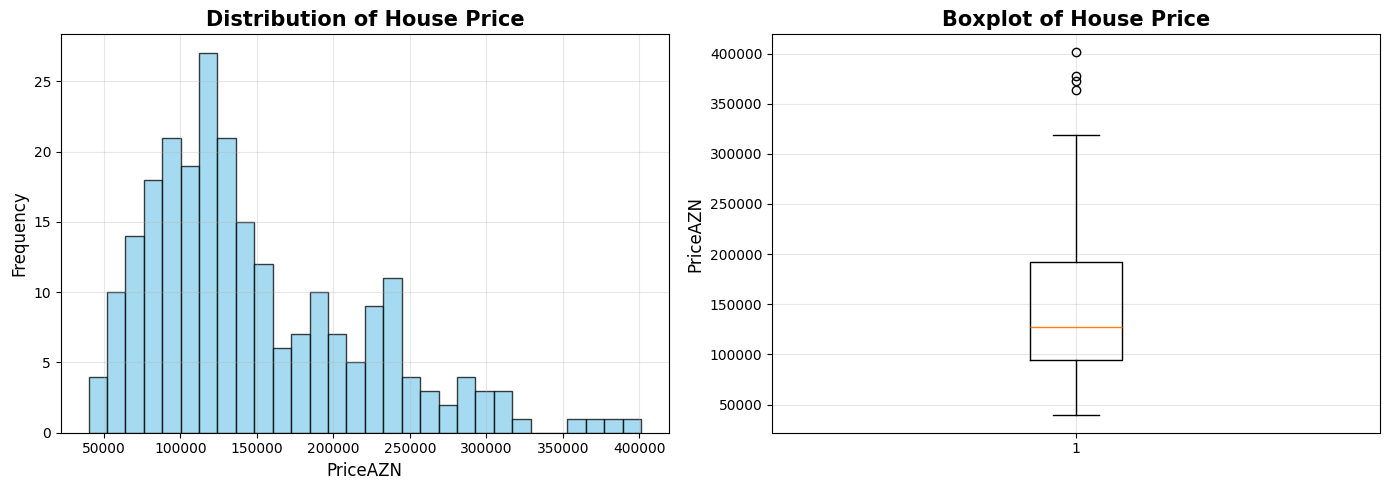

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=30, color='skyblue', edgecolor='black', alpha=0.75)
axes[0].set_title('Distribution of House Price', fontsize=15, fontweight='bold')
axes[0].set_xlabel('PriceAZN', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True , alpha=0.3)

axes[1].boxplot(y, vert=True)
axes[1].set_title('Boxplot of House Price', fontsize=15, fontweight='bold')
axes[1].set_ylabel('PriceAZN', fontsize=12)
axes[1].grid(True , alpha=0.3)
plt.tight_layout()

In [9]:
y.describe()

count       240.000000
mean     147927.083333
std       71134.645560
min       40000.000000
25%       94400.000000
50%      126950.000000
75%      192525.000000
max      401100.000000
Name: PriceAZN, dtype: float64

In [10]:
X.describe()

,Bedrooms,Bathrooms,Sqm
count,240.000000,240.00000,240.000000
mean,2.908333,2.01250,92.547917
std,1.420094,0.82066,27.146753
min,1.000000,1.00000,45.000000
25%,2.000000,1.00000,72.200000
50%,3.000000,2.00000,92.750000
75%,4.000000,3.00000,110.700000
max,5.000000,3.00000,171.100000


In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])



preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [12]:
numeric_transformer

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

In [14]:
pipeline = Pipeline(
    steps=[
        ('prep', preprocessor),
        ('model', rf)
    ]
)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((192, 4), (48, 4))

In [16]:
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_absolute_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("=" * 50)
print("Model metrics:")
print("=" * 50)
print(f"MAE: {mae:.2f}", )
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print("=" * 50)

Model metrics:
MAE: 15489.78
RMSE: 124.46
R2: 0.8941


In [18]:
test_predictions = pd.DataFrame({
    "Bedrooms": [2],
    "Bathrooms": [3],
    "Sqm":[56],
    "City": ["Sumqayit"],
})
prediction = pipeline.predict(test_predictions)[0]
print(f"Predicted price: {prediction:.0f} AZN")

Predicted price: 81720 AZN


In [19]:
from pathlib import Path
import joblib

bundle = {
    "pipeline": pipeline,
    "featured_order": ['Bedrooms', 'Bathrooms', 'Sqm', 'City']
}

model_path = Path("../ai/models/model_az.pkl")
model_path.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(bundle, model_path)

['..\\ai\\models\\model_az.pkl']